##### <font size ="4">**Importing all the libraries**</font>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to /home/u194148/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u194148/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [2]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

<font size="4">**Read the data csv file**</font>

In [3]:
fake_data = pd.read_csv('data/Fake.csv')
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true_data = pd.read_csv('data/True.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Assigning Classes to the Dataset

In [5]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [6]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

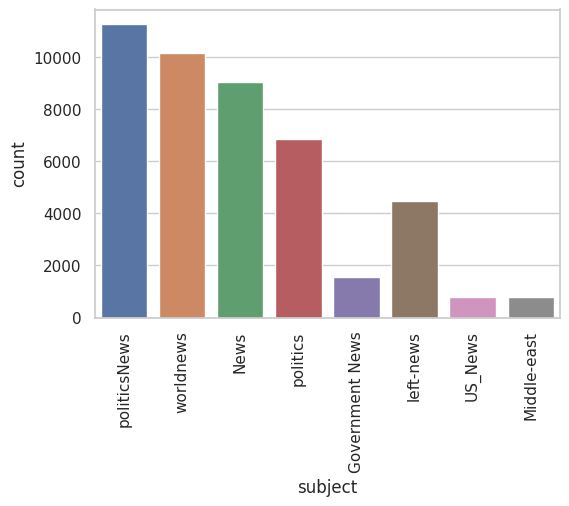

In [7]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<font size="4">**Data preprocessing**</font>

In [8]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [9]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [10]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [11]:
# get the count of missing/NULL values for each column. if present remove missing values
null_values = data.isnull().sum()

# Drop rows with null values
data = data.dropna()

# Verify if null values have been dropped
null_values_after_drop = data.isnull().sum()

 Now we have to shuffle the dataset to prevent the model to get bias

In [12]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,Trump says to approve lifting restrictions on ...,1
1,Ted Nugent Reveals The Most Anti-American Thi...,0
2,‘No F*cks Left’ Obama Just Crushed The Last O...,0
3,DOJ CONTINUES OBSESSION WITH DISCREDITING FERG...,0
4,Jeff Sessions orders review of gun background ...,1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

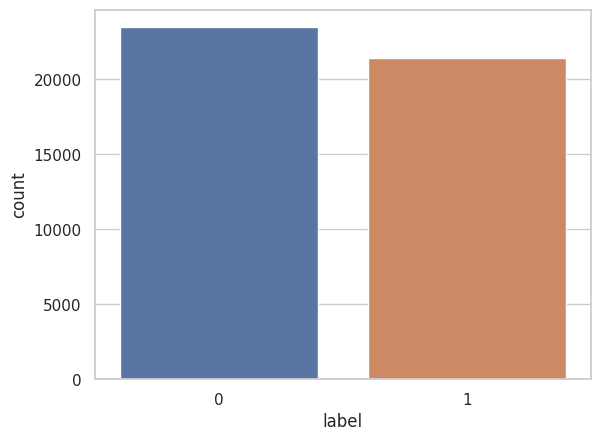

In [13]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [14]:
def preprocess_text(text):
    text = text.lower()
    text=re.sub(r"@\S+","",text)
    text=re.sub("http[s]?\://\S+","",text)
    text=re.sub(r"#\S+","",text)
    text=re.sub(r'[^\w\s]',"",text)
    text=re.sub(r"[0-9]","",text)
    text=re.sub(r"\n","",text)
    return text
data['text'] = data['text'].apply(preprocess_text)
print(data)

                                                    text  label
0      trump says to approve lifting restrictions on ...      1
1       ted nugent reveals the most antiamerican thin...      0
2       no fcks left obama just crushed the last of t...      0
3      doj continues obsession with discrediting ferg...      0
4      jeff sessions orders review of gun background ...      1
...                                                  ...    ...
44893  watch fox and friends host brian kilmeade imme...      0
44894  clinton leads trump by  points in reutersipsos...      1
44895  saudi crown prince calls iran leader new hitle...      1
44896  oops obama tells troops no foreign terror atta...      0
44897  merkels social democrat rival bullish ahead of...      1

[44898 rows x 2 columns]


<font size="4">**Converting text into Vectors**</font>

In [15]:
#Assigning title contents to X and label contents to Y
X=data['text'].values
Y=data['label'].values

#Converting textual data to numerical data
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
vectorizer.fit(X)
X = vectorizer.transform(X)

#Split the data into training and test sets  
x_train, x_test, y_train, y_test = train_test_split( X, Y , test_size=0.2, stratify= Y, random_state=5)



<font size="4">**Model training, Evaluation, and Prediction**</font>

In [16]:
#training

model= LogisticRegression()
model.fit(x_train, y_train)

#evaluation

#training data aacuracy
x_train_prediction = model.predict(x_train)
training_data_accuracy = accuracy_score(x_train_prediction, y_train)
print(f'Accuracy of training data : {round(training_data_accuracy*100,2)}%')

#test data accuracy
x_test_prediction = model.predict(x_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)
print(f'Accuracy of test data : {round(test_data_accuracy*100,2)}%')

Accuracy of training data : 99.38%
Accuracy of test data : 98.52%


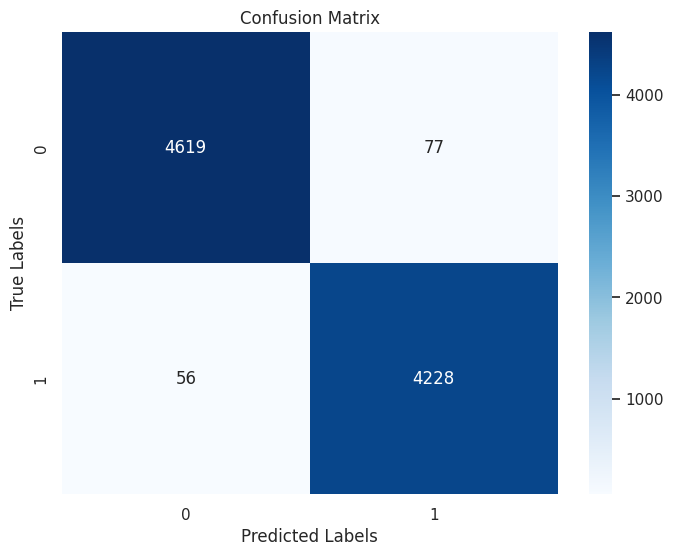

In [17]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, x_test_prediction)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [18]:
#Predictive system

#Example 1
x_example1 = x_test[500] 
prediction = model.predict(x_example1)
print('Prediction =',prediction)
print('Test =',y_test[500])
if prediction[0]==1:
    print('The news is real')
else: 
    print('The news is fake')

Prediction = [0]
Test = 0
The news is fake


In [19]:
#Example 2
x_example2 = x_test[105] 
prediction = model.predict(x_example2)
print('Prediction =',prediction)
print('Test =',y_test[105])
if prediction[0]==1:
    print('The news is real')
else: 
    print('The news is fake')

Prediction = [1]
Test = 1
The news is real
